# Calibration (SIR model)
Using generated data, we test if we can infer that a lockdown has happened and how the contact parameters have changed.
To do this, we generate a test trajectory with a lockdown at time $20$. 
The lockdown is implemented by scaling the contact matrices (for work, school, other).
We use the data points up to the lockdown to infer the parameters of the SIR model.
Using the data after lockdown and the inferred parameters, we infer the change of the contact structure.

For the pre-intervention period, we infer the following parameters: 
* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals),
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

For the post-intervention period, we infer the following control parameters: 
* $a_\mathrm{W}$ fraction of work contact, 
* $a_\mathrm{S}$ fraction of social contact, 
* $a_\mathrm{O}$ fraction of other contacts 

In [1]:
%matplotlib inline
import numpy as np
import pyross
import time
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory

In [2]:
# population and age classes (4 age groups)
M=4  # number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()

CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]

In [3]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)

In [4]:
T_intervention = 30
times= [T_intervention] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.8, 0.7, 0.7

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [5]:
beta  = 0.04       # contact rate parameter
gIa   = 1./7       # recovery rate of asymptomatic infectives 
gIs   = 1./7       # recovery rate of symptomatic infectives 
alpha = 0.2        # asymptomatic fraction
fsa   = 0.8        # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*20
Is_0[1] += 10  #make one group different 
Ia_0 = np.zeros((M))*2
Ia_0[1] += 2 
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
true_parameters = parameters
model = pyross.stochastic.SIR(parameters, M, Ni)

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, C, Tf, Nf, method='tau-leaping')

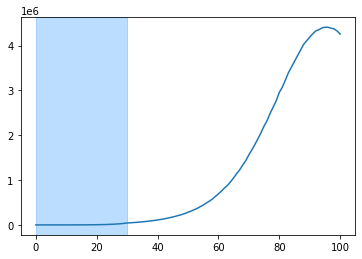

In [6]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.show() 

## 2) Infer the parameters of the model

1314.2017457358438
0.2314927577972412


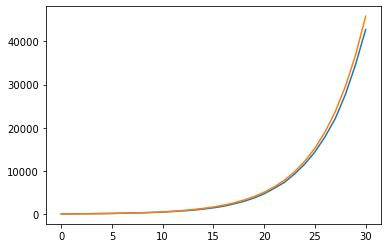

In [7]:
Tf = 30 # truncate to only getting the first few datapoints (up to lockdown) 
Nf = Tf+1

x = data['X'].astype('float')
x = x[:Nf]

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, Ni)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, C)
end_time = time.time()
print(logp) 
print(end_time - start_time)

# Check the deterministic simulation against stochstic simulations with the same parameters and initial conditions 
# They are likely to be different due to the inherent stochasticity of the model 
Tf_initial = T_intervention # truncate to only getting the pre-intervention trajectory 
Nf_initial = Tf_initial+1
contactMatrix = generator.constant_contactMatrix()
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
xm = estimator.integrate(x[0], 0, Tf_initial, Nf_initial)
t = np.linspace(0, Tf_initial, Nf_initial)
plt.plot(t, np.sum(x[:,2*M:3*M], axis=1))
plt.plot(t, np.sum(xm[:,2*M:3*M], axis=1))
plt.show()

In [8]:
# take a guess 
eps = 1e-4 
priors = {
    'alpha':{
        'mean': 0.3, 
        'std': 0.2, 
        'bounds': [eps, 0.8]
    }, 
    'beta':{
        'mean': 0.05, 
        'std': 0.1, 
        'bounds': [eps, 0.2]
    }, 
    'gIa':{
        'mean': 0.1, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': 0.2, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }
}
estimator.set_lyapunov_method('euler')
start_time = time.time() 



#old function call: deprecated but still working (as a wrapper of infer)
#res = estimator.infer_parameters(x, Tf_initial, contactMatrix, priors, tangent=True, 
#                                    global_max_iter=20, local_max_iter=400,
#                                    cma_population=16, global_atol=1,
#                                    ftol=1e-6, verbose=True, cma_random_seed=413788650)
res = estimator.infer(x, Tf_initial, priors, contactMatrix=contactMatrix, tangent=True, 
                                    global_max_iter=20, local_max_iter=400,
                                    cma_population=16, global_atol=1,
                                    ftol=1e-6, verbose=True, cma_random_seed=413788650)
end_time = time.time()

print(res['params_dict']) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=413788650, Sat Jul 25 17:00:41 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.541572329143176e+04 1.0e+00 9.15e-01  5e-02  2e-01 0:00.1
    2     32 1.671132766929424e+04 1.4e+00 7.78e-01  4e-02  2e-01 0:00.1
    3     48 1.454405426886573e+04 1.6e+00 6.94e-01  3e-02  1e-01 0:00.2
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  1398.739551234569
Starting local minimisation...
Optimal value (local minimisation):  1374.9859288771784
{'alpha': 0.16708850012206938, 'beta': 0.040233977025659694, 'gIa': 0.08354211485560095, 'gIs': 0.15837624238917875, 'fsa': array([0.8, 0.8, 0.8, 0.8])}
2.3855268955230713


In [9]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(res['params_dict'])

True parameters:
{'alpha': 0.2, 'beta': 0.04, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8}

Inferred parameters:
{'alpha': 0.16708850012206938, 'beta': 0.040233977025659694, 'gIa': 0.08354211485560095, 'gIs': 0.15837624238917875, 'fsa': array([0.8, 0.8, 0.8, 0.8])}


## 3) Infer the change of contact structure

In [10]:
priors = {
    'aW':{
        'mean': 0.8, 
        'std': 0.1, 
        'bounds': [0.1, 1]
    }, 
    'aS':{
        'mean': 0.7,
        'std': 0.1, 
        'bounds': [0.1, 1]
    }, 
    'aO':{
        'mean': 0.7, 
        'std': 0.1, 
        'bounds': [0.1, 1]
    }
}

x = data['X'].astype('float')
x = x[T_intervention+1:]
Nf = x.shape[0] 
Tf = Nf-1 

contactMatrix = generator.constant_contactMatrix(aW=aW, aS=aS, aO=aO)

# compute -log_p for the initial guess (for the moment, use correct parameters)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, contactMatrix)
print(logp) 

808767.3036715772


In [11]:
eps = 1e-3 
start_time = time.time() 

best_estimates = res['params_dict']
estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
# estimator.set_det_method('LSODA') # slower but performs better for exponential decay (near the end of the pandemic)
#old function call: deprecated but still working (as a wrapper of infer)
#res = estimator.infer_control(x, Tf, generator, priors, 
#                                         tangent=True, verbose=True, 
#                                         global_max_iter=20, cma_random_seed=1266266794)
res = estimator.infer(x, Tf, priors, generator=generator,
                                         tangent=True, verbose=True, 
                                         global_max_iter=20, cma_random_seed=1266266794)

end_time = time.time()

print(res['control_params_dict']) 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=1266266794, Sat Jul 25 17:00:43 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 5.496985407505587e+05 1.0e+00 8.57e-01  7e-02  8e-02 0:00.1
    2     32 5.370759532482162e+05 1.4e+00 6.47e-01  5e-02  6e-02 0:00.2
    3     48 5.335590596864047e+05 1.8e+00 4.89e-01  3e-02  3e-02 0:00.3
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  528537.5129068784
Starting local minimisation...
Optimal value (local minimisation):  528537.5043153893
{'aW': 0.804296015457644, 'aS': 0.7052877522429492, 'aO': 0.7026634679416359}
2.8672173023223877


In [12]:
print("True lockdown factors:")
print([aW, aS, aO])

print("\nInferred lockdown factors:")
print(res['control_params_dict'])

True lockdown factors:
[0.8, 0.7, 0.7]

Inferred lockdown factors:
{'aW': 0.804296015457644, 'aS': 0.7052877522429492, 'aO': 0.7026634679416359}


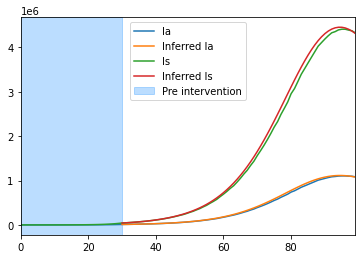

In [13]:
times = [T_intervention]
interventions = [[1.0,1.0,1.0],      # before first time
                 res['flat_params'],       # after first time
                ]         

# compare the true trajectory with the 
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
x = data['X'].astype('float')
estimator.set_det_method('LSODA') # setting deterministic integration to be LSODA 
x_det_control = estimator.integrate(x[T_intervention], T_intervention, Tf+T_intervention, Nf)
plt.plot(np.sum(x[:,M:2*M], axis=1), label='Ia')
plt.plot(np.linspace(T_intervention, Tf+T_intervention, Nf), np.sum(x_det_control[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='Is')
plt.plot(np.linspace(T_intervention, Tf+T_intervention, Nf), np.sum(x_det_control[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf+T_intervention])
plt.legend()
plt.show()

## 4) Now, instead of assuming a step-function like change at T_intervention, allow for anticipation time and reaction time 

For this, we make use of the `intervention_custom_temporal` function in the contactMatrix module. First we need to define our intervention function. We use a tanh to represent anticipation and reaction, and parameterise it with four parameters: 

* width: the width of the tanh profile 
* loc: the location of the interface of the tanh 
* aW_f: the final aW_f of the lockdown 
* aS_f: the final aS_f of the lockdown 
* aO_f: the fianl aO_f of the lockdown 

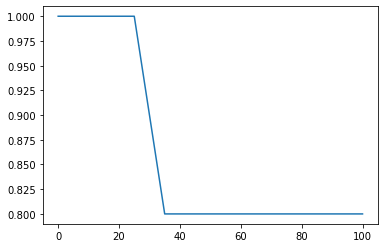

In [14]:
def approx_tanh(t, width, loc):
    cond1 = (t < loc-width/2)
    cond2 = (t >= loc+width/2)
    cond3 = np.logical_and((t < loc+width/2), (t >= loc-width/2))
    cond_list = [cond1, cond2, cond3]
    fun_list = [-1, 1, lambda t: 2*(t-loc)/width]
    return np.piecewise(t, cond_list, fun_list)
    
def intervention_fun(t, M, width=1, loc=0, aW_f=0, aS_f=0, aO_f=0):
    aW = (1-approx_tanh(t, width, loc))/2*(1-aW_f) + aW_f
    aS = (1-approx_tanh(t, width, loc))/2*(1-aS_f) + aS_f
    aO = (1-approx_tanh(t, width, loc))/2*(1-aO_f) + aO_f
    aW_full = np.full((2, M), aW) # must return the full (2, M) array 
    aS_full = np.full((2, M), aS)
    aO_full = np.full((2, M), aO)
    return aW_full, aS_full, aO_full

aW_f = 0.8 
aS_f = 0.7
aO_f = 0.7


# plot aW as a function of t 
width = 10
loc = T_intervention 
time_points = np.linspace(0, 100, 1001)
aW_time_series = np.empty((1001,), dtype='float')
for (i, t) in enumerate(time_points): 
    aW_time_series[i] = intervention_fun(t, 4, width, loc, aW_f, aS_f, aO_f)[0][0, 0]
plt.plot(time_points, aW_time_series)
plt.show()

In [15]:
contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                       width=width, loc=loc, 
                                                       aW_f=aW_f, aS_f=aS_f, aO_f=aO_f)

# initial conditions    
Is_0 = np.ones(M)*20
Is_0[1] += 10  #make one group different 
Ia_0 = np.zeros((M))*2
Ia_0[1] += 2 
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf, method='tau-leaping')

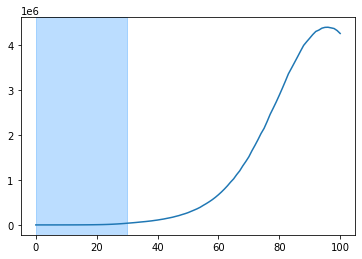

In [16]:
# plot simulation
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.show() 

### For this part, we use simultaneous inference of model parameters and control parameters

In [17]:
x = data['X'].astype('float')
x = x[:60]
Nf = x.shape[0] 
Tf = Nf-1 

contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                       width=width, loc=loc, 
                                                       aW_f=aW_f, aS_f=aS_f, aO_f=aO_f)

# compute -log_p 

estimator = pyross.inference.SIR(parameters, M, Ni)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, contactMatrix)
print(logp) 

9184.384347324341


In [18]:
priors = {
    'alpha':{
        'mean': 0.3, 
        'std': 0.2, 
        'bounds': [eps, 0.8]
    }, 
    'beta':{
        'mean': 0.05, 
        'std': 0.1, 
        'bounds': [eps, 0.2]
    }, 
    'gIa':{
        'mean': 0.1, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': 0.2, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    },
    'width':{
        'mean': 10,
        'std': 5, 
        'bounds': [1e-3, 40]
    }, 
    'loc':{
        'mean': 35, 
        'std': 10, 
        'bounds': [1e-3, 100]
    }, 
    'aW_f':{
        'mean': 0.8, 
        'std': 0.2, 
        'bounds': [0.1, 1.0]
    }, 
    'aS_f':{
        'mean': 0.7, 
        'std': 0.1, 
        'bounds': [0.1, 1.0]
    }, 
    'aO_f':{
        'mean': 0.7, 
        'std': 0.1, 
        'bounds': [0.1, 1.0]
    }
}

start_time = time.time() 
estimator.set_det_method('LSODA') # slower but performs better for exponential decay (near the end of the pandemic)
estimator.set_lyapunov_method('euler') # fast integration method for lyapunov
res = estimator.infer(x, Tf, priors, generator=generator,
                             intervention_fun=intervention_fun, tangent=False,
                             verbose=True, cma_random_seed=1953449819)
end_time = time.time()



print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 9 (seed=1953449819, Sat Jul 25 17:00:48 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.364740464870922e+05 1.0e+00 8.34e-01  5e-02  8e+00 0:00.7
    2     32 2.723531347696462e+05 1.3e+00 8.15e-01  5e-02  8e+00 0:01.4
    3     48 3.208772559855519e+05 1.4e+00 8.07e-01  4e-02  8e+00 0:02.1
    8    128 1.369264751237505e+05 1.9e+00 6.81e-01  3e-02  6e+00 0:05.5
   15    240 3.763390467844751e+04 3.7e+00 4.77e-01  1e-02  4e+00 0:09.8
   23    368 2.450015730667870e+04 5.8e+00 3.16e-01  5e-03  3e+00 0:14.9
   33    528 1.256951629720725e+04 9.7e+00 2.03e-01  3e-03  2e+00 0:21.1
   46    736 1.023609394935213e+04 1.9e+01 1.03e-01  9e-04  8e-01 0:28.6
   59    944 9.939127724884311e+03 2.8e+01 5.46e-02  4e-04  4e-01 0:36.8
   70   1120 9.616002509919212e+03 4.3e+01 9.22e-02  5e-04  8e-01 0:46.1
   82   1312 9.503087958686436e+03 6.5e+01 5.83e-02  4e-04  5e-01 0:56.

In [19]:
print("True model parameters:")
print(parameters) 
print("Inferred model parameters:")
print(res['params_dict']) 
print("True control parameters:")
print([width, loc, aW_f, aS_f, aO_f])
print("Inferred control parameters:")
print(res['control_params_dict'])

True model parameters:
{'alpha': 0.2, 'beta': 0.04, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8}
Inferred model parameters:
{'alpha': 0.19902092897940898, 'beta': 0.03955196566744634, 'gIa': 0.1408685356891959, 'gIs': 0.14194606639718604, 'fsa': array([0.8, 0.8, 0.8, 0.8])}
True control parameters:
[10, 30, 0.8, 0.7, 0.7]
Inferred control parameters:
{'width': 10.233804666810922, 'loc': 30.125869123523426, 'aW_f': 0.8004618947418386, 'aS_f': 0.7000002788804587, 'aO_f': 0.7018513663859101}


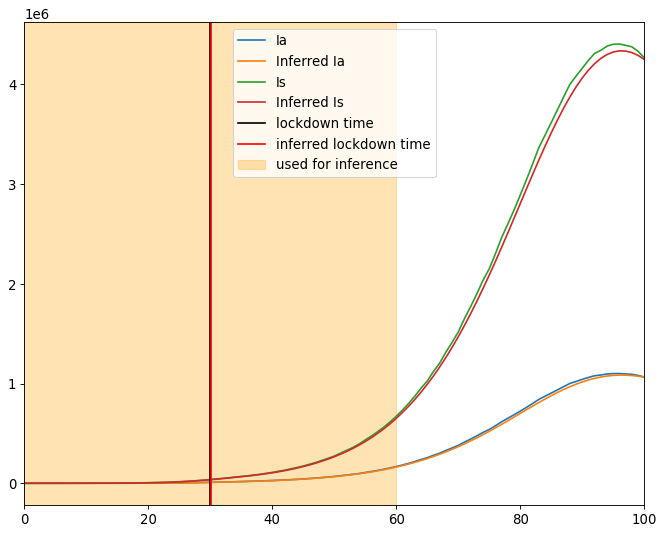

In [20]:
# compare the true trajectory with the deterministic solution with MAP parameters
Tf = 100 
Nf = Tf + 1 


inferred_contactMatrix = generator.intervention_custom_temporal(intervention_fun, **res['control_params_dict'])
estimator.set_det_model(res['params_dict'])
estimator.set_contact_matrix(inferred_contactMatrix)
x_true = data['X'][:Nf].astype('float')
x_det_control = estimator.integrate(x_true[0], 0, Tf, Nf)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x_true[:,M:2*M], axis=1), label='Ia')
plt.plot(np.sum(x_det_control[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x_true[:,2*M:3*M], axis=1), label='Is')
plt.plot(np.sum(x_det_control[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.axvline(x=T_intervention, label='lockdown time', color='black')
plt.axvline(x=res['control_params_dict']['loc'], label='inferred lockdown time', color='red')
plt.axvspan(0, 60, 
           label='used for inference',
           alpha=0.3, color='orange')
plt.xlim([0, Tf])
plt.legend()
plt.show()

